In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal

import h5py
from DasTools import DasPrep as dp

datapath = 'H:\\shanghai_chongming\\Chongming_test\\'
workpath = 'D:\\sustech_dir\\shanghai_chongming_das\\Chongming_Locate\\locate_temp\\'
hs_catalog_file = 'D:\\sustech_dir\\shanghai_chongming_das\\Chongming_Locate\\RTK_coor_time_shanghai.csv'

Load RTK coordinates and times for tap tests

In [3]:
hs_cat = pd.read_csv(hs_catalog_file, sep=',')
hs_cat.head(5)

,latitude,longitude,Elevation,Date,Time
0,31.676389,121.544597,16.388404,2023/6/7,6:58:07
1,31.676384,121.544649,16.352978,2023/6/7,6:59:19
2,31.676382,121.544706,16.067803,2023/6/7,7:00:34
3,31.676356,121.544809,16.129463,2023/6/7,7:03:44
4,31.676308,121.544934,16.165311,2023/6/7,7:05:05


In [4]:
def get_cat_time(catalog):
    cat_time = np.array([datetime.datetime.strptime(str(catalog['Date'].values[i])+' '+str(catalog['Time'].values[i]), '%Y/%m/%d %H:%M:%S') 
       for i in range(len(catalog))])
    return cat_time

hs_time = get_cat_time(hs_cat)

lat = hs_cat['latitude'].values
lon = hs_cat['longitude'].values
dep = hs_cat['Elevation'].values

In [5]:
hs_time

array([datetime.datetime(2023, 6, 7, 6, 58, 7),
       datetime.datetime(2023, 6, 7, 6, 59, 19),
       datetime.datetime(2023, 6, 7, 7, 0, 34),
       datetime.datetime(2023, 6, 7, 7, 3, 44),
       datetime.datetime(2023, 6, 7, 7, 5, 5),
       datetime.datetime(2023, 6, 7, 7, 6, 1),
       datetime.datetime(2023, 6, 7, 7, 7, 15),
       datetime.datetime(2023, 6, 7, 7, 10, 5),
       datetime.datetime(2023, 6, 7, 7, 12, 7),
       datetime.datetime(2023, 6, 7, 7, 13, 12),
       datetime.datetime(2023, 6, 7, 7, 15, 11),
       datetime.datetime(2023, 6, 7, 7, 16, 39),
       datetime.datetime(2023, 6, 7, 7, 22, 44),
       datetime.datetime(2023, 6, 7, 7, 26, 2),
       datetime.datetime(2023, 6, 7, 7, 27, 24),
       datetime.datetime(2023, 6, 7, 7, 28, 56),
       datetime.datetime(2023, 6, 7, 7, 36, 17),
       datetime.datetime(2023, 6, 7, 7, 37, 26),
       datetime.datetime(2023, 6, 7, 7, 38, 37),
       datetime.datetime(2023, 6, 7, 7, 41, 41),
       datetime.datetime(2023, 

# 2023/06/14 Modification for Shanghai Chongming 2D DAS array:

## Sort out the order of the latlon coordinates according to the cable layout

## Use this "sorted array order" to sort any arrays related to taps (e.g., lat, lon, dep, rms_all)

## The rest remain the same

<IPython.core.display.Javascript object>


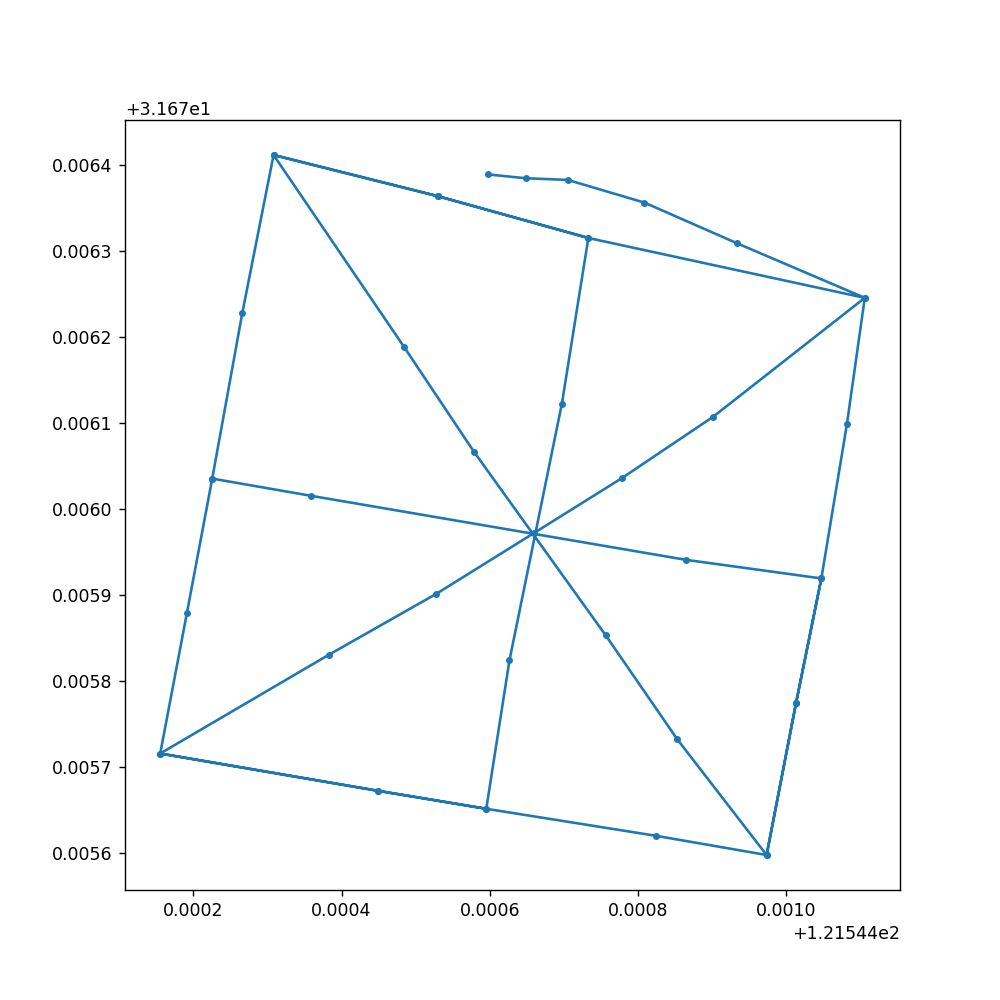

In [102]:
%matplotlib notebook
plt.figure(figsize=[8,8])

# array_order_0 = np.r_[0:10, 10:14, 14:18, 18:20, 20:25, 25:29, 29:31, 31:33]
array_order_1 = np.r_[0:10, 28:24:-1, 17:20, 32:30:-1, 11:14, 24:19:-1, 5, 19:6:-1, 29:31, 15] 


# plt.plot(lon, lat,'r.-')
plt.plot(lon[array_order_1], lat[array_order_1],'.-')

Read DAS filenames and parameters

In [8]:
%%time
das_file = glob.glob(datapath+'*.h5')
das_file.sort()

Wall time: 14.1 ms


In [9]:
das_file

['H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055153.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055223.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055253.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055323.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055353.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055423.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055453.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055523.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_20230607_055553.514.h5',
 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m

In [10]:
# # get_das_file_time(das_file[0])

# dp.read_das(das_file[0], metadata='True')

Cut tap test events

In [11]:
def read_das_data(filename):
    data= dp.read_das(filename)
    dt = dp.read_das(das_file[0], metadata='True')['dt']
    nt = data.shape[1]
    return data, dt, nt

def get_das_file_time(das_filename, das_name_format):
    return datetime.datetime.strptime(das_filename, das_name_format)

def get_ev_id_in_das_window(event_time_arr, start_time, end_time):
    return np.where((event_time_arr > start_time) & (event_time_arr < end_time))

def get_time_step(start, end, dt):
    return int((start - end).total_seconds() / dt + 1)


def extract_das_data(das_file, das_name_format, ev_time, dt_before, dt_after, save_file_name_prefix, overwrite=False, verbose=False):
    
    das_file_time = np.array([get_das_file_time(das_file[i], das_name_format) for i in range(len(das_file))])
    
    ev_id_in_das_win = get_ev_id_in_das_window(ev_time, das_file_time.min(), das_file_time.max())
    ev_time_in_das_win = ev_time[ev_id_in_das_win]
    
    ev_time_before = ev_time_in_das_win - datetime.timedelta(seconds=dt_before)
    ev_time_after  = ev_time_in_das_win + datetime.timedelta(seconds=dt_after)

    for iev in range(len(ev_id_in_das_win[0])):

        savename = save_file_name_prefix + str(ev_id_in_das_win[0][iev]) + '.npy'
        
        if verbose: print(savename)

        if not (os.path.exists(savename) and not overwrite):

            ins_start = np.searchsorted(das_file_time, ev_time_before[iev:(iev+1)])[0] - 1
            ins_end = np.searchsorted(das_file_time, ev_time_after[iev:(iev+1)])[0]

            das_file_time_select = das_file_time[ins_start:ins_end]
            das_file_select = das_file[ins_start:ins_end]

            ev_t0 = ev_time_before[iev]
            ev_t1 = ev_time_after[iev]

            data = []
            for i in range(len(das_file_select)):
#                 print(das_file_select[i])

                datatmp, dt, nt = read_das_data(das_file_select[i])
                istart, iend = 0, np.copy(nt)

                das_t0 = das_file_time_select[i]
                das_t1 = das_t0 + datetime.timedelta(seconds=dt*nt)

                if ev_t0 > das_t0:
                    istart = get_time_step(ev_t0, das_t0, dt)

                if ev_t1 < das_t1:
                    iend = get_time_step(ev_t1, das_t0, dt)

                data.append(datatmp[:, istart:iend])

            data = np.concatenate(data, axis=1)
            if (data.size > 0):
                np.save(savename, data.astype('float32'))

In [13]:
%%time

das_name_format = 'H:\\shanghai_chongming\\Chongming_test\\Chongming_GL_5m_frq_1kHz_sp_05m_UTC_%Y%m%d_%H%M%S.%f.h5'

dt_before, dt_after = 0, 10

save_file_name_prefix = workpath + 'Chongming_rtk_'

extract_das_data(das_file, das_name_format, hs_time, dt_before, dt_after, 
                 save_file_name_prefix, overwrite=False, verbose=True)

D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_0.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_1.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_2.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_3.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_4.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_5.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_6.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_7.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_8.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_9.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_10.npy
D:\sustech_dir\shanghai_chongming_das\Chon

In [14]:
def bandpass(data, dt, fl, fh):
    fs=1/dt
    sos = signal.butter(6, [fl/(fs/2), fh/(fs/2)], 'bp', output='sos')
    data = signal.sosfiltfilt(sos, data, axis=1)
    return data


D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_15.npy


<IPython.core.display.Javascript object>


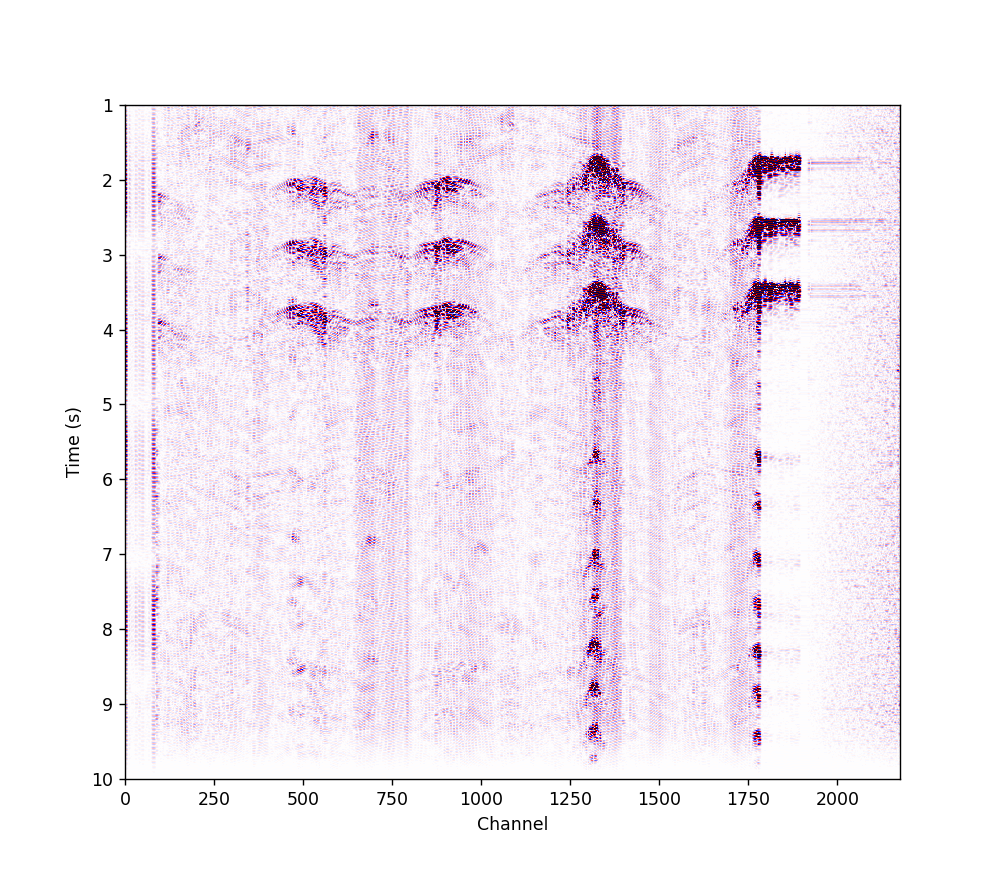

In [16]:
%matplotlib notebook

import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

save_file_name_prefix = workpath + 'Chongming_rtk_'

iev = 15
# if len(list(click_pos.keys()))>0:
#     iev = max(list(click_pos.keys())) + 1
# else:
#     iev = 21

savename = save_file_name_prefix + str(iev) + '.npy'

dt = 1./1000.
print(savename)
data = np.load(savename)

data = dp.das_preprocess(data)
f1, f2 = 20, 499
data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)


# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,7])

clim = data.std() 

ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

ax.set_ylim([10, 1])
ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')


def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k")
    axx.axvline(x=event.xdata, color="k")
    
def onMouseClick(event, axx):
    click_pos[iev] = (event.xdata, event.ydata)
    axx.scatter(x=event.xdata, y=event.ydata)

def visualize(i):
#     line1.set_ydata(val1)
    return None
    

click = das_mp.Click(ax, onMouseClick, button=1)
mm    = das_mp.MouseMove(ax, onMouseMove)

ani = animation.FuncAnimation(fig, visualize, interval=1)

# plt.axvline(iev*4/0.5+ 128)

plt.show()

In [17]:
%%time
rms_all = []

dt = 1./1000.

for iev in range(33):

    savename = save_file_name_prefix + str(iev) + '.npy'

    
    print(savename)
    data = np.load(savename)

    data = dp.das_preprocess(data)
    f1, f2 = 20, 499
    data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

    rms = np.sqrt((data[:,:]**2).mean(axis=1))
    
    rms_all.append(rms)

D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_0.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_1.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_2.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_3.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_4.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_5.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_6.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_7.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_8.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_9.npy
D:\sustech_dir\shanghai_chongming_das\Chongming_Locate\locate_temp\Chongming_rtk_10.npy
D:\sustech_dir\shanghai_chongming_das\Chon

In [18]:
rms_all = np.asarray(rms_all)

np.save('shot_rms.npy', rms_all)

<IPython.core.display.Javascript object>


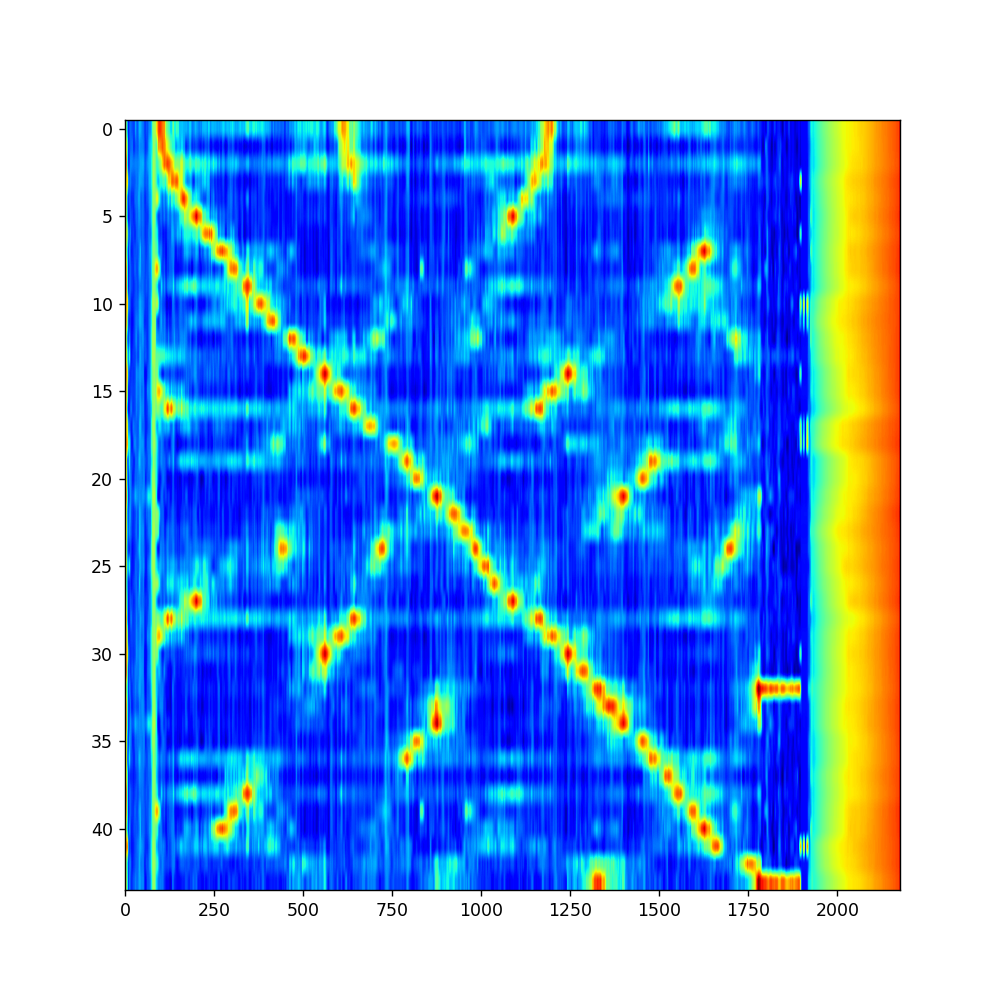

In [103]:
plt.figure(figsize=[8,8])
plt.imshow(np.log10(rms_all)[array_order_1,:], aspect='auto', cmap='jet')
plt.show()

In [104]:
click_pos = {}

<IPython.core.display.Javascript object>


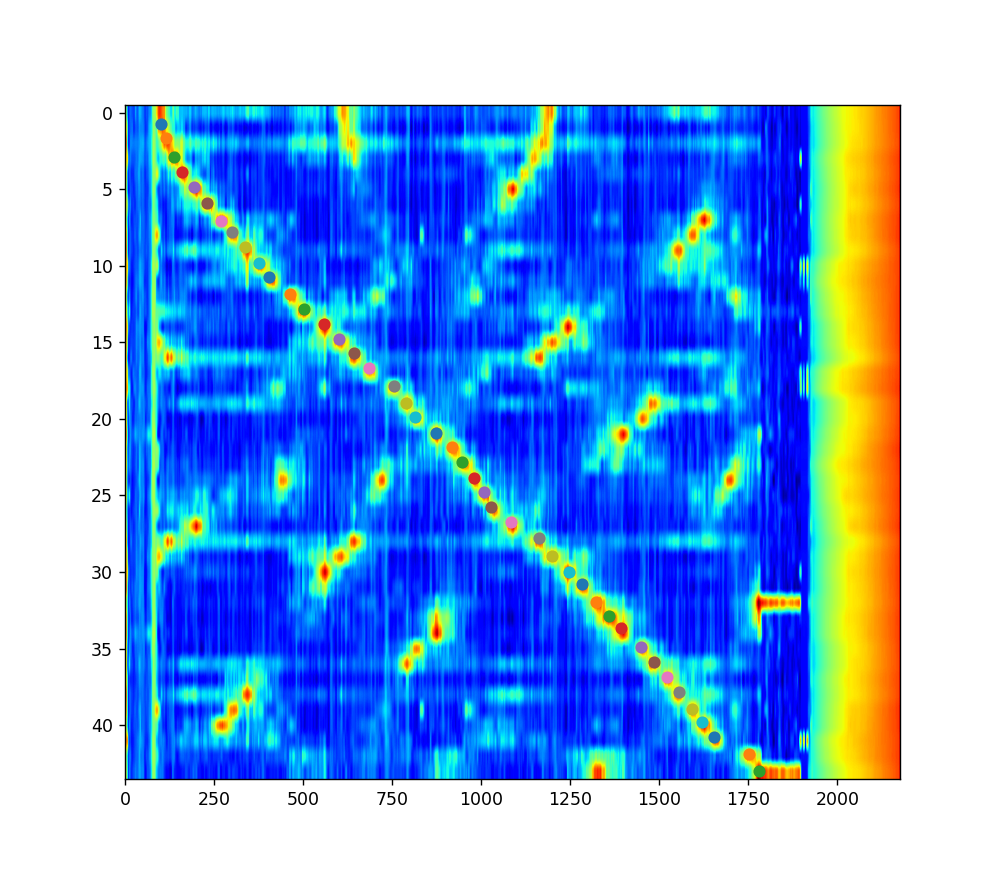

In [106]:
%matplotlib notebook

import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

fig, ax = plt.subplots(figsize=[8,7])
ax.imshow(np.log10(rms_all)[array_order_1,:], aspect='auto', cmap='jet')



def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k")
    axx.axvline(x=event.xdata, color="k")
    
def onMouseClick(event, axx):
    click_pos[int(event.ydata)] = event.xdata 
    axx.scatter(x=event.xdata, y=event.ydata)

def visualize(i):
#     line1.set_ydata(val1)
    return None
    

click = das_mp.Click(ax, onMouseClick, button=1)
mm    = das_mp.MouseMove(ax, onMouseMove)

ani = animation.FuncAnimation(fig, visualize, interval=1)

plt.show()

In [107]:
click_pos

{0: 100.66649445564519,
 1: 114.70520413306451,
 2: 135.76326864919355,
 3: 160.33101058467741,
 4: 191.91810735887094,
 5: 230.52455897177418,
 7: 300.718107358871,
 8: 335.8148815524193,
 9: 374.42133316532255,
 10: 402.4987525201613,
 11: 462.1632686491935,
 12: 500.76972026209677,
 13: 556.9245589717741,
 14: 599.0406880040323,
 15: 641.1568170362902,
 16: 683.2729460685482,
 17: 753.466494455645,
 18: 788.5632686491936,
 19: 813.1310105846774,
 20: 872.7955267137097,
 21: 918.4213331653225,
 22: 946.4987525201611,
 23: 978.0858492943548,
 24: 1006.1632686491935,
 25: 1027.2213331653224,
 26: 1083.376171875,
 27: 1160.5890751008064,
 28: 1199.1955267137096,
 29: 1244.8213331653226,
 30: 1283.4277847782257,
 31: 1322.0342363911288,
 32: 1357.1310105846774,
 33: 1392.2277847782257,
 34: 1448.3826234879032,
 35: 1483.4793976814515,
 36: 1522.0858492943548,
 37: 1553.6729460685483,
 38: 1592.2793976814514,
 39: 1620.3568170362903,
 40: 1651.9439138104838,
 41: 1750.2148815524192,
 43: 

In [110]:
irtk, ichn = [], []
for i in click_pos.keys():
    irtk.append(int(i))
    ichn.append(click_pos[i])  
    
irtk = np.array(irtk)
ichn = np.array(ichn)

In [111]:
irtk

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43])

In [112]:
ichn

array([ 100.66649446,  114.70520413,  135.76326865,  160.33101058,
        191.91810736,  230.52455897,  300.71810736,  335.81488155,
        374.42133317,  402.49875252,  462.16326865,  500.76972026,
        556.92455897,  599.040688  ,  641.15681704,  683.27294607,
        753.46649446,  788.56326865,  813.13101058,  872.79552671,
        918.42133317,  946.49875252,  978.08584929, 1006.16326865,
       1027.22133317, 1083.37617187, 1160.5890751 , 1199.19552671,
       1244.82133317, 1283.42778478, 1322.03423639, 1357.13101058,
       1392.22778478, 1448.38262349, 1483.47939768, 1522.08584929,
       1553.67294607, 1592.27939768, 1620.35681704, 1651.94391381,
       1750.21488155, 1778.29230091])

In [122]:

from sklearn.linear_model import LinearRegression
import pyproj
 
def lat_lon_dep_to_interval(lat, lon, dep):
    geodesic = pyproj.Geod(ellps='WGS84')
    HdL = np.array([geodesic.inv(lon[i], lat[i], lon[i+1], lat[i+1])[2] for i in range(len(lon)-1)])
    dL = np.sqrt(HdL**2 + np.diff(dep)**2)
    return dL

def linRegModel(x,y):
    return LinearRegression().fit(x.reshape(-1,1), y)

def interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length, lat, lon, dep):
    x_ch = np.arange(int(rtk_hit_chn.min())-1000, int(rtk_hit_chn.max())+1000)
    x_rtk = ch2rtk.predict(x_ch.reshape(-1,1))

    xch_min, xch_max = np.argwhere(x_rtk<rtk_length[0]).max(), np.argwhere(x_rtk>rtk_length[-1]).min()
   
    x_lat = np.interp(x_rtk, rtk_length, lat)[xch_min:xch_max]
    x_lon = np.interp(x_rtk, rtk_length, lon)[xch_min:xch_max]
    x_dep = np.interp(x_rtk, rtk_length, dep)[xch_min:xch_max]
    x_chn = x_ch[xch_min:xch_max]
    
    return x_chn, x_lat, x_lon, x_dep

In [123]:
# add the array_order_1 to coordinates

rtk_hit_chn = ichn

rtk_dL = lat_lon_dep_to_interval(lat[array_order_1], lon[array_order_1], dep[array_order_1]) 
rtk_length = np.r_[0, rtk_dL].cumsum()

ch2rtk = linRegModel(rtk_hit_chn, rtk_length[irtk])

x_chn, x_lat, x_lon, x_dep = interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length[irtk], 
                                                     lat[array_order_1][irtk], lon[array_order_1][irtk], dep[array_order_1][irtk])

<IPython.core.display.Javascript object>


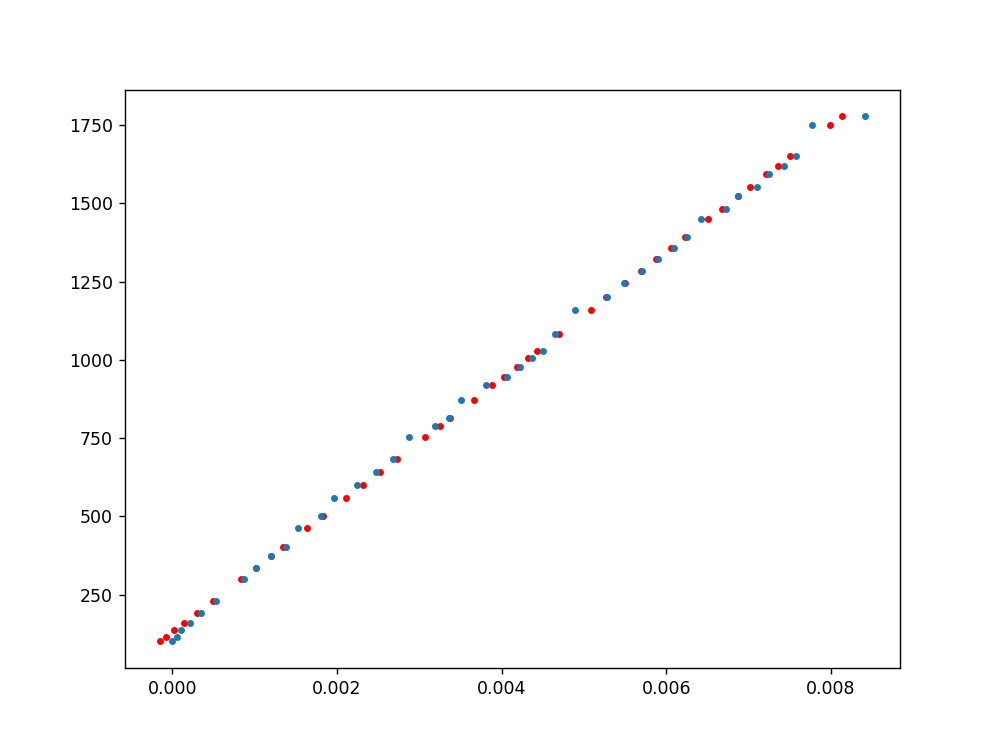

In [124]:
%matplotlib notebook
plt.figure(figsize=[8,6])
plt.plot(ch2rtk.predict(rtk_hit_chn.reshape(-1,1)), rtk_hit_chn, 'r.')
plt.plot(rtk_length[irtk], rtk_hit_chn, '.')

<IPython.core.display.Javascript object>


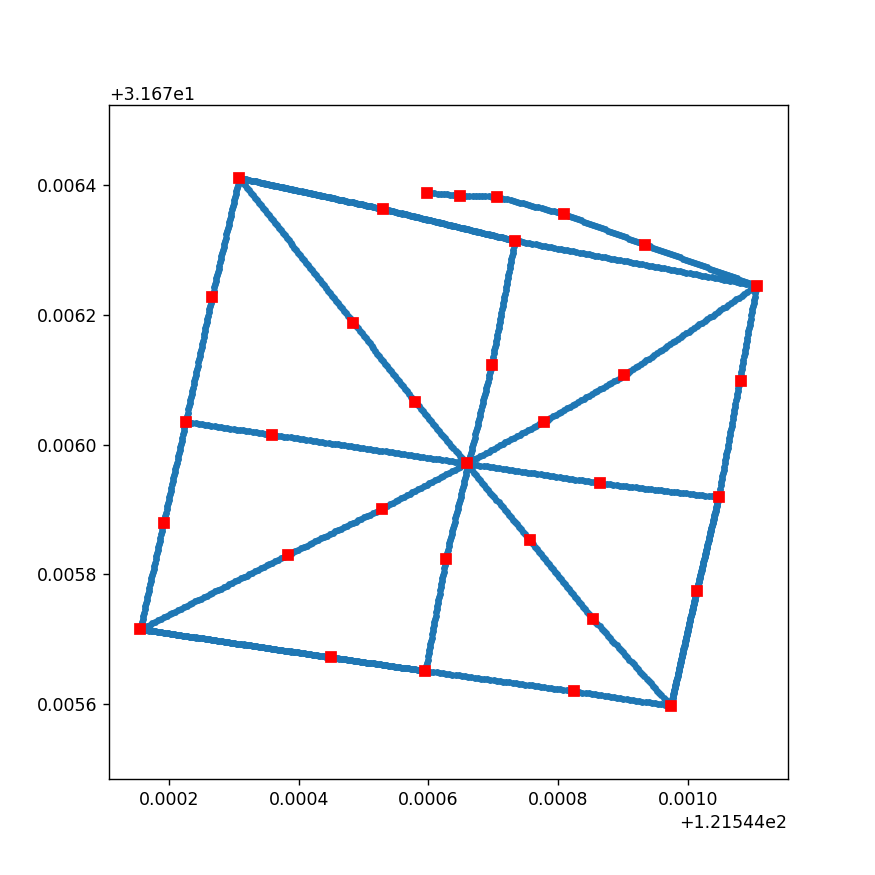

In [137]:
plt.figure(figsize=[7,7])
plt.plot(x_lon, x_lat,'.')
plt.plot(lon, lat, 'rs')
plt.axis('equal')
plt.show()

In [127]:
# np.savetxt('shanghai_chongming_das_coordinates.txt', np.stack([x_chn, x_lon, x_lat, x_dep]).T, fmt='%d,%f,%f,%f', delimiter=',')

In [131]:
coors = np.loadtxt('shanghai_chongming_das_coordinates.txt', delimiter=',')

<IPython.core.display.Javascript object>


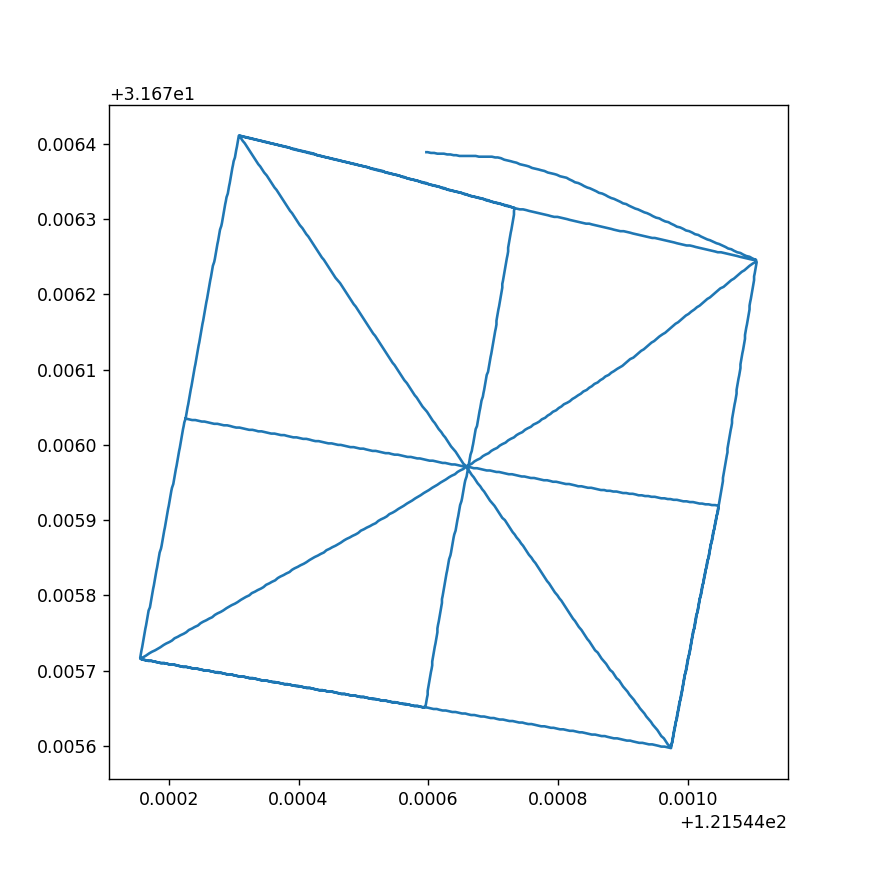

In [136]:
plt.figure(figsize=[7,7])
plt.plot(coors[:,1], coors[:,2])